In [1]:
import pandas as pd

df = pd.read_csv('../cellula toxic data  (1).csv')

unique_cats = df['Toxic Category'].unique()
print("Unique Categories:", unique_cats)

print("\nCounts per Category:")
print(df['Toxic Category'].value_counts())

Unique Categories: ['Safe' 'Violent Crimes' 'Elections' 'Sex-Related Crimes' 'unsafe'
 'Non-Violent Crimes' 'Child Sexual Exploitation' 'Unknown S-Type'
 'Suicide & Self-Harm']

Counts per Category:
Toxic Category
Safe                         995
Violent Crimes               792
Non-Violent Crimes           301
unsafe                       274
Unknown S-Type               196
Sex-Related Crimes           115
Suicide & Self-Harm          114
Elections                    110
Child Sexual Exploitation    103
Name: count, dtype: int64


In [2]:
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')    
# nltk.download('omw-1.4') 
# nltk.download('averaged_perceptron_tagger_eng') 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

merged_Text="<query> " + df['query']+" <image_desc> " +df['image descriptions']
tokenized_rows = [nltk.word_tokenize(text) for text in merged_Text]
filtered_tokens = [
    [word for word in row if word.lower() not in stop_words] 
    for row in tokenized_rows
]



lemmatized_words = [
    [lemmatizer.lemmatize(word) for word in row ] 
    for row in filtered_tokens
]




In [3]:
from collections import Counter


all_words = [word for row in lemmatized_words for word in row]
word_counts = Counter(all_words)

sorted_words = word_counts.most_common(len(all_words))

vocab_to_int = {w: i+2 for i, (w, c) in enumerate(sorted_words)}
vocab_to_int['<PAD>'] = 0
vocab_to_int['<UNK>'] = 1
vocab_size = len(vocab_to_int) + 1
print(f"Vocabulary Size: {vocab_size}")



encoded_data = []
for row in lemmatized_words:  
    encoded_row = [vocab_to_int.get(word, 1) for word in row]
    encoded_data.append(encoded_row)

max_len = max([len(row) for row in encoded_data])

print(f"Longest sentence found: {max_len} words")

data = []
for row in encoded_data:
    zeros_needed = max_len - len(row)
    pad_list = [0] * zeros_needed
    new_row = pad_list + row 
    
    data.append(new_row)

X = np.array(data)

print("Simple padding complete!")

label_map = {label: ids for ids, label in enumerate(unique_cats)}
label_ids = df['Toxic Category'].map(label_map)
y = label_ids.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")
print(f"X_test length:  {len(X_test)}")
print(f"y_test length:  {len(y_test)}")


Vocabulary Size: 4200
Longest sentence found: 109 words
Simple padding complete!
X_train length: 2400
y_train length: 2400
X_test length:  600
y_test length:  600


In [21]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, vocab_size):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(vocab_size, input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        
        self.fc = nn.Linear(hidden_dim *2, output_dim)

    def forward(self, x, h0=None, c0=None):
        direction_multiplier = 2 if self.lstm.bidirectional else 1
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim * direction_multiplier, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim * direction_multiplier, x.size(0), self.hidden_dim).to(x.device)
        emb = self.embedding(x)
        out,(hn, cn) = self.lstm(emb, (h0, c0))
        out = self.fc(out[:, -1, :])  
        return out

In [22]:
model = LSTMModel(input_dim=300, hidden_dim=128, layer_dim=1, output_dim=len(unique_cats),vocab_size=vocab_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

loss_history = []

LSTMModel(
  (embedding): Embedding(4200, 300)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)


In [ ]:
import matplotlib.pyplot as plt
num_epochs = 100
h0, c0 = None, None
X_train = torch.LongTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)

local_loss_history = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train, h0, c0)

    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    local_loss_history.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0129
Epoch [2/100], Loss: 0.0128
Epoch [3/100], Loss: 0.0126
Epoch [4/100], Loss: 0.0124
Epoch [5/100], Loss: 0.0122
Epoch [6/100], Loss: 0.0120
Epoch [7/100], Loss: 0.0119
Epoch [8/100], Loss: 0.0118
Epoch [9/100], Loss: 0.0116
Epoch [10/100], Loss: 0.0115
Epoch [11/100], Loss: 0.0113
Epoch [12/100], Loss: 0.0112
Epoch [13/100], Loss: 0.0110
Epoch [14/100], Loss: 0.0109
Epoch [15/100], Loss: 0.0108
Epoch [16/100], Loss: 0.0106
Epoch [17/100], Loss: 0.0105
Epoch [18/100], Loss: 0.0104
Epoch [19/100], Loss: 0.0103
Epoch [20/100], Loss: 0.0102
Epoch [21/100], Loss: 0.0100
Epoch [22/100], Loss: 0.0099
Epoch [23/100], Loss: 0.0098
Epoch [24/100], Loss: 0.0097
Epoch [25/100], Loss: 0.0096
Epoch [26/100], Loss: 0.0095
Epoch [27/100], Loss: 0.0094
Epoch [28/100], Loss: 0.0093
Epoch [29/100], Loss: 0.0092
Epoch [30/100], Loss: 0.0091
Epoch [31/100], Loss: 0.0091
Epoch [32/100], Loss: 0.0090
Epoch [33/100], Loss: 0.0089
Epoch [34/100], Loss: 0.0088
Epoch [35/100], Loss: 0

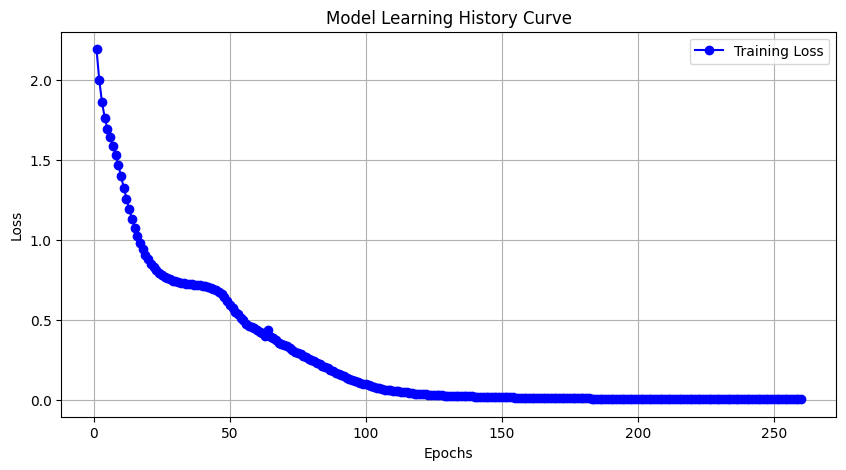

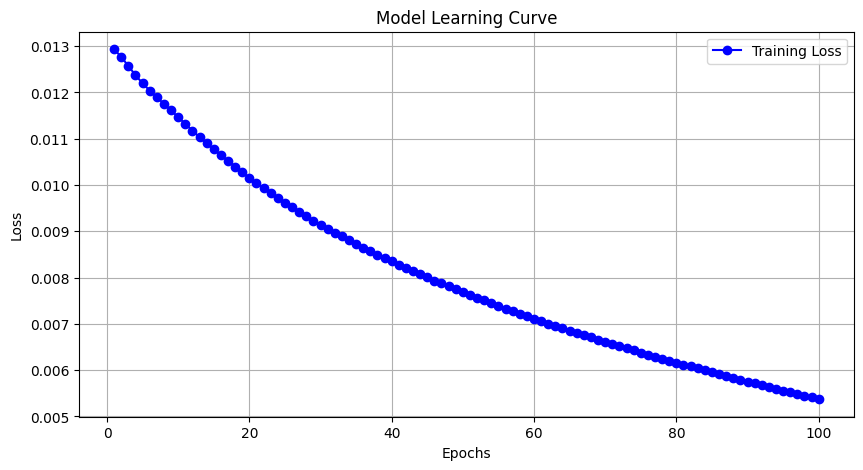

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(1,len(loss_history)+1), loss_history, label='Training Loss', color='blue', marker='o')
plt.title('Model Learning History Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), local_loss_history, label='Training Loss', color='blue', marker='o')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Test Accuracy: 92.50%

-------------------------------------------------------
              CLASSIFICATION REPORT
-------------------------------------------------------
                           precision    recall  f1-score   support

                     Safe       0.96      0.80      0.87       187
           Violent Crimes       1.00      1.00      1.00       175
                Elections       1.00      1.00      1.00        20
       Sex-Related Crimes       1.00      1.00      1.00        22
                   unsafe       1.00      1.00      1.00        59
       Non-Violent Crimes       1.00      1.00      1.00        57
Child Sexual Exploitation       1.00      1.00      1.00        24
           Unknown S-Type       0.43      0.81      0.56        36
      Suicide & Self-Harm       1.00      1.00      1.00        20

                 accuracy                           0.93       600
                macro avg       0.93      0.96      0.94       600
             weighted a

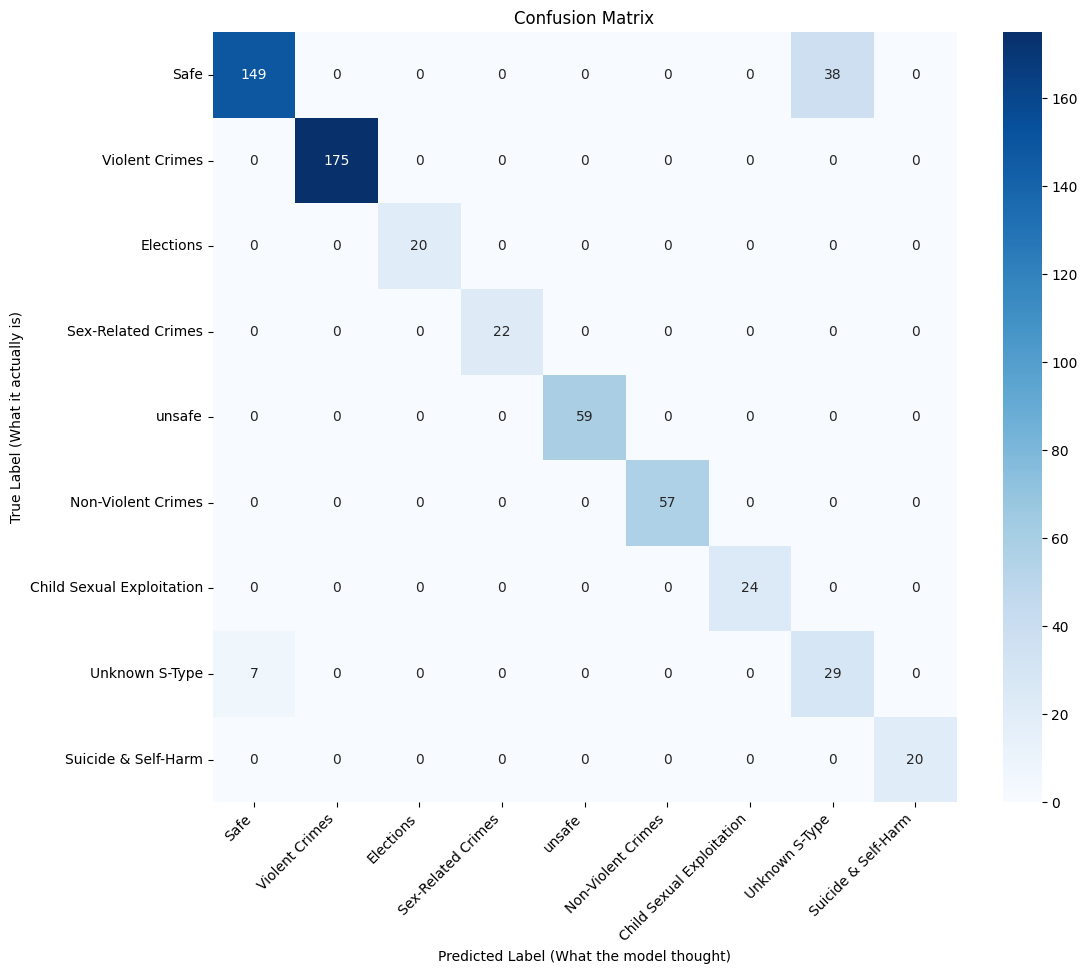

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


model.eval()  
with torch.no_grad():
   
    X_test_tensor = torch.LongTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)
    
    test_outputs = model(X_test_tensor, None, None)
    
    _, predicted_ids = torch.max(test_outputs, 1)

y_true = y_test_tensor.cpu().numpy()
y_pred = predicted_ids.cpu().numpy()

print(f"Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%\n")

class_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

print("-------------------------------------------------------")
print("              CLASSIFICATION REPORT")
print("-------------------------------------------------------")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label (What it actually is)')
plt.xlabel('Predicted Label (What the model thought)')
plt.xticks(rotation=45, ha='right')
plt.show()